# Membuat Sentiment Analysis dari Tweets

**1. Persiapan Data**

**Install Packages**

Pada pengerjaan ini, ada beberapa packages yang digunakan yaitu:

In [1]:
#!pip install nltk

In [2]:
#!pip install symspellpy

In [3]:
#!pip install spacy

In [4]:
#!pip install Sastrawi

In [5]:
#!pip install swifter

In [6]:
#!pip install wordcloud

In [7]:
#!pip install gensim

In [8]:
#!pip install python-pcre

In [9]:
#!pip install pymysql

In [10]:
#!pip install mysql-connector-python-rf

In [11]:
#conda update anaconda

In [12]:
#!pip install --upgrade pip

In [13]:
#!pip install --upgrade jupyter notebook

In [14]:
#!pip install little-mallet-wrapper

In [15]:
#!pip install pyLDAvis

In [16]:
#!pip install seaborn

In [17]:
#!pip install --upgrade ipykernel

In [18]:
#!pip install flair

**Melakukan Import Library**

Pertama, lakukan import library yang dibutuhkan berikut:

In [19]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#import libraries
import pandas as pd 
import numpy as np
import string 
import re
import spacy
import ast
import glob
import json
import random
import collections
import datetime
import lemmatizer as lemma
import mysql.connector
import pickle
import pyLDAvis
import nltk

%matplotlib inline
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
from matplotlib import pyplot as plt
from wordcloud import STOPWORDS
from wordcloud import WordCloud 
from nltk.corpus import stopwords
from operator import itemgetter
from scipy import stats
from datetime import datetime
from mysql.connector import errorcode

from nltk.corpus import stopwords
import seaborn as sns

# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

#import gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from pprint import pprint

/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


Selanjutnya, lakukan download resources dari NLTK untuk proses text processing

In [20]:
#nltk.download('punkt')

In [21]:
#nltk.download('stopwords')

## Persiapan Data

Deklarasi date_start dan date_end untuk masing-masing periode sebelum dan saat COVID-19 memetakan label setiap periodenya

In [22]:
from datetime import date

date_start = date(2019,12,13)
date_end   = date(2020,6,13)

date_start_convert = date_start.strftime('%d%m%Y')
date_end_convert = date_end.strftime('%d%m%Y')

**Mengambil Data Retweets Pengguna**

Lakukan load data retweets beserta data username penggunanya dari file CSV

In [23]:
#read file CSV
retweets_df = pd.read_csv('data/interractions/covid/retweets_data_after_joining_13122019-13062020.csv')
retweets_copy_df = retweets_df[['tweet_id','conversation_id','username', 'user_id', 'tweet', 'retweet', 'date_created', 'language']].copy()
retweets_copy_df['date_created']= pd.to_datetime(retweets_copy_df['date_created'])
retweets_copy_df['date'] = retweets_copy_df['date_created'].dt.date
retweets_copy_df['time'] = retweets_copy_df['date_created'].dt.time
del retweets_copy_df["date_created"]

**Mengambil Data Tweets Pengguna**

Lakukan load data tweets beserta data username penggunanya dari file CSV

In [24]:
#read file CSV
tweets_during_covid_df = pd.read_csv('data/filter/covid/tweet_after_filter_14032020-13062020.csv')
tweets_during_covid_copy_df = tweets_during_covid_df[['id','conversation_id','username', 'user_id', 'tweet', 'retweet', 'date', 'time', 'language']].copy()
tweets_during_covid_copy_df = tweets_during_covid_copy_df.rename(columns={'id': 'tweet_id'})

/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1,2,10,16,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Menggabungkan data Retweets dengan Tweets**

Lakukan penggabungan data retweets dan tweets

In [25]:
#gabungkan data
result_data_during_covid = pd.concat([tweets_during_covid_copy_df, retweets_copy_df])
#ganti value 1 menjadi True pada kolom retweet
result_data_during_covid['retweet'] = result_data_during_covid['retweet'].replace([1],'True')
#menghapus dupicat kolom
result_data_during_covid=result_data_during_covid.loc[:, ~result_data_during_covid.columns[::-1].duplicated()[::-1]]

print("Jumlah Data: ", len(result_data_during_covid))

Jumlah Data:  467470


### Text Processing

**Menyeleksi Data Tweet**

Menyeleksi dan memilih data tweet yang memiliki jumlah kata lebih dari 5. INi sesuai dari referesi artikel pad

In [26]:
def selected_tweet(tweet_data_df):
    #memilih data tweet yang berbahasa indonesia
    tweet_data_df = tweet_data_df[(tweet_data_df['language'] == 'in')]
    
    #menghapus karakter spesial dari data tweet
    case_folding_result = case_folding(tweet_data_df)
    special_char_result = special_char(case_folding_result)
    
    #memilih data tweet yang memiliki lebih dari 5 kata
    tweet_data_df['tweet_length'] = [len(x.split()) for x in special_char_result['tweet_char'].tolist()]
    tweet_data_df = tweet_data_df[(tweet_data_df['tweet_length']>=5)]
    
    return tweet_data_df

**Melakukan Case Folding**

*Case folding* bertujuan untuk mengubah semua huruf dalam sebuah dokumen teks menjadi huruf kecil (lowercase)

In [27]:
# gunakan fungsi Series.str.lower() pada Pandas
def case_folding(tweet_data_df):
    tweet_data_df['tweet_char'] = tweet_data_df['tweet'].str.lower()
    
    return tweet_data_df

**Menghapus Spesial Karakter**

Proses ini digunakan untuk menghapus number, link, punctuation, single char, space, entities, mention, hastag dan karakter spesial lain.

In [28]:
def remove_tweet_special(text):
    # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove incomplete URL
    text = text.replace("http://", " ").replace("https://", " ")
    # Remove every retweet symbol
    text = re.sub('(?i)rt',' ',text)
    # Remove every username
    text = re.sub('@[^\s]+[ \t]','',text)
     # Remove every username
    text = re.sub('(?i)user','',text)
    # Remove every url
    text = re.sub('(?i)url',' ',text)
    # Remove every emoji
    text = re.sub(r'\\x..',' ',text)
    # Remove extra spaces
    text = re.sub('  +', ' ', text)
    #Remove characters repeating more than twice
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text) 
    
    return text

def strip_links(text):
    # remove link
    text = re.sub(r'pic.twitter.com.[\w]+', '', text) # Remove every pic 
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ', text)
    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

#remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def special_char(tweet_data_df):
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_tweet_special)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(strip_links)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(strip_all_entities)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_number)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_punctuation)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_whitespace_LT)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_whitespace_multiple)
    tweet_data_df['tweet_char'] = tweet_data_df['tweet_char'].swifter.apply(remove_singl_char)
    
    return tweet_data_df

<>:3: DeprecationWarning: invalid escape sequence \.
<>:14: DeprecationWarning: invalid escape sequence \s
<>:31: DeprecationWarning: invalid escape sequence \.
<>:62: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \.
<>:14: DeprecationWarning: invalid escape sequence \s
<>:31: DeprecationWarning: invalid escape sequence \.
<>:62: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \.
<>:14: DeprecationWarning: invalid escape sequence \s
<>:31: DeprecationWarning: invalid escape sequence \.
<>:62: DeprecationWarning: invalid escape sequence \s
<ipython-input-28-1a33ec4cff09>:3: DeprecationWarning: invalid escape sequence \.
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
<ipython-input-28-1a33ec4cff09>:14: DeprecationWarning: invalid escape sequence \s
  text = re.sub('@[^\s]+[ \t]','',text)
<ipython-input-28-1a33ec4cff09>:31: DeprecationWarning: invalid escape 

**Tokenizing**

*Tokenizing* adalah operasi memisahkan teks menjadi potongan-potongan berupa token, bisa berupa potongan huruf, kata, atau kalimat, sebelum dianalisis lebih lanjut. Entitas yang bisa disebut sebagai token misalnya kata, angka, simbol, tanda baca, dan lain sebagainya

In [29]:
# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)
    
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
# create N-grams
def make_n_grams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)  # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold=100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    bigrams_text = [bigram_mod[doc] for doc in texts]
    trigrams_text =  [trigram_mod[bigram_mod[doc]] for doc in bigrams_text]
    return trigrams_text

def first_step_tokenizing(tweet_data_df):
    #tweet_data_df['tweet_tokens'] = tweet_data_df['tweet'].apply(word_tokenize_wrapper)
    tweet_data_df['tweet_tokens'] = list(sent_to_words(tweet_data_df['tweet_char']))
    tweet_data_df['tweet_tokens'] = make_n_grams(tweet_data_df['tweet_tokens'])
    
    return tweet_data_df

def second_step_tokenizing(tweet_data_df):
    #tweet_data_df['tweet_tokens'] = tweet_data_df['tweet'].apply(word_tokenize_wrapper)
    tweet_data_df['tweet_tokens2'] = list(sent_to_words(tweet_data_df['tweet_normalized']))
    tweet_data_df['tweet_tokens2'] = make_n_grams(tweet_data_df['tweet_tokens2'])
    
    return tweet_data_df

**Menghitung Frekwensi**

Melakukan perhitungan frekuensi distribusi token pada tiap row data pada Dataframe 

In [30]:
# NLTK calc frequency distribution
def freqDist_wrapper(text):
    return FreqDist(text)

def count_frequency(tweet_data_df):
    tweet_data_df['tweet_tokens_fdist'] = tweet_data_df['tweet_tokens'].swifter.apply(freqDist_wrapper)

    return tweet_data_df

**Filtering (Stopword Removal)**

Menghilangkan kata umum (*common words*) yang biasanya muncul dalam jumlah besar dan dianggap tidak memiliki makna.

In [174]:
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')

# append additional stopword
#list_stopwords.extend(['test'])

# read txt stopword using pandas

txt_stopword1 = pd.read_csv("KK/Final Project/resources/stopwords/stopwords.txt", names= ["stopwords"], header = None)
txt_stopword2 = pd.read_csv("KK/Final Project/resources/stopwords/stopword2.txt", names= ["stopwords"], header=None)
txt_stopword3 = pd.read_csv("KK/Final Project/resources/unimportant text/unimportant-text.txt", names= ["stopwords"], header=None)
txt_stopword4 = pd.read_csv("KK/Final Project/resources/stopwords/stopwords4.csv", names= ["stopwords"], header = None)
txt_stopword5 = pd.read_csv("KK/Final Project/resources/unimportant text/other-unimportant-text.txt", names= ["stopwords"], header=None)

txt_stopword1 = txt_stopword1["stopwords"][0].split(' ')
txt_stopword2 = txt_stopword2["stopwords"][0].split(' ')
txt_stopword3 = txt_stopword3["stopwords"][0].split(' ')
txt_stopword4 = txt_stopword4["stopwords"][0].split(' ')
txt_stopword5 = txt_stopword5["stopwords"][0].split(' ')
        
# convert stopword string to list & append additional stopword
list_stopwords.extend(txt_stopword1)
list_stopwords.extend(txt_stopword2)
list_stopwords.extend(txt_stopword3)
list_stopwords.extend(txt_stopword4)
list_stopwords.extend(txt_stopword5)

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    words = ast.literal_eval(words)
    
    #filtered_sentence = [word for word in words if not word in list_stopwords]
    filtered_sentence = [] 
    
    for word in list(words):
        tokens = word.split(' ')
        
        if len(tokens)> 1:
            for token in list(tokens):
                if token not in list_stopwords: 
                    filtered_sentence.append(token) 
            
        else:
            if word not in list_stopwords: 
                filtered_sentence.append(word) 
    
    return filtered_sentence
        
#function
def first_step_stopwords_process(tweet_data_df):
    tweet_data_df['tweet_tokens_WSW'] = (tweet_data_df['tweet_post_tag'].apply(stopwords_removal))

    return tweet_data_df

#function
def second_step_stopwords_process(tweet_data_df):
    tweet_data_df['tweet_tokens_final'] = (tweet_data_df['tweet_tokens_lemma'].swifter.apply(stopwords_removal))

    return tweet_data_df

**Normalization**

Normalization digunakan untuk menyeragamkan term yang memiliki makna sama namun penulisanya berbeda, bisa diakibatkan kesalahan penulisan, penyingkatan kata, ataupun “bahasa gaul”.

In [33]:
#file1
normalizad_word1 = pd.read_csv("KK/Final Project/resources/slang words/colloquial-indonesian-lexicon.csv")
#file2
normalizad_word2 = pd.read_csv("KK/Final Project/resources/slang words/kamusalay.csv", header=None)
#file3
file = open("KK/Final Project/resources/slang words/combined_slang_words.txt", "r")
contents = file.read()
normalizad_word3 = ast.literal_eval(contents)
file.close()
#file4
normalizad_word4 = pd.read_csv("KK/Final Project/resources/slang words/new_kamusalay.csv", header=None)
#file5
normalizad_word5 = pd.read_csv('KK/Final Project/resources/slang words/kbba.txt', sep="\t", header=None)

normalizad_word_dict = {}

for index, row in normalizad_word1.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 
        
for index, row in normalizad_word2.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 
        
for index in normalizad_word3.keys():
    if index not in normalizad_word_dict:
        normalizad_word_dict[index] = normalizad_word3[index]

for index, row in normalizad_word4.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]
        
for index, row in normalizad_word5.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

def normalization(tweet_data_df):
    tweet_data_df['tweet_normalized'] = tweet_data_df['tweet_tokens'].swifter.apply(normalized_term)

    return tweet_data_df

**Stemming**

Function stemmer dari library Sastrawi untuk mengembalikan kata kebentuk dasarnya. Karena fungsi stemmer.stem() pada library Sastrawi lambat, kita dapat menggunakan library swifter untuk mempercepat froses stemming pada Dataframe dengan menjalankan task secara parallel. Kecepatan pemrosesan bisa dua kali bahkan lebih cepat jika tanpa menggunakan swifter.

In [34]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

def stemming(tweet_data_df):
    for document in tweet_data_df['tweet_tokens_WSW']:
        for term in document:
            if term not in term_dict:
                term_dict[term] = ' '

    for term in term_dict:
        term_dict[term] = stemmed_wrapper(term)
        #print(term,":" ,term_dict[term])

    tweet_data_df['tweet_tokens_stemmed'] = tweet_data_df['tweet_tokens_WSW'].swifter.apply(get_stemmed_term)
    #print(tweet_data_df['tweet_tokens_stemmed'])

    return  tweet_data_df

**Lemmatization**

In [35]:
def lemmatization_process(tweet_data_df):
    lem = lemma.Lemmatizer()
    _stopwords_ = stopwords.words('indonesian')
    
    lemmatized_sent = []
    
    for token in tweet_data_df:
        lemmatized = lem.lemmatize(token)
        
        if(type(lemmatized) == tuple):
            lemmatized_sent.append(lemmatized[0])
        else:
            lemmatized_sent.append(lemmatized)
            
    return lemmatized_sent
    
def lemmatization(tweet_data_df):
            
    tweet_data_df['tweet_tokens_lemma'] = tweet_data_df['tweet_tokens_stemmed'].swifter.apply(lemmatization_process)

    return  tweet_data_df

**POS Tagging**

In [36]:
from flair.data_fetcher import NLPTaskDataFetcher, NLPTask
corpus = NLPTaskDataFetcher.load_corpus(NLPTask.UD_INDONESIAN)

tag_type = 'upos'
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)

from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, BertEmbeddings
from typing import List

from flair.data import Sentence
from flair.models import SequenceTagger

embedding_types: List[TokenEmbeddings] = [ 
    WordEmbeddings('id-crawl'),
    WordEmbeddings('id'),
]
embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

from flair.models import SequenceTagger
tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                      tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

tag_pos = SequenceTagger.load('resources/taggers/example-universal-pos/best-model.pt')

2021-06-10 08:05:15,434 Reading data from /Users/toniafriantoni/.flair/datasets/ud_indonesian
2021-06-10 08:05:15,435 Train: /Users/toniafriantoni/.flair/datasets/ud_indonesian/id_gsd-ud-train.conllu
2021-06-10 08:05:15,435 Dev: /Users/toniafriantoni/.flair/datasets/ud_indonesian/id_gsd-ud-dev.conllu
2021-06-10 08:05:15,436 Test: /Users/toniafriantoni/.flair/datasets/ud_indonesian/id_gsd-ud-test.conllu


/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) load_corpus. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  
/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:226: DeprecationWarning: Call to deprecated function (or staticmethod) load_ud_corpus. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  return NLPTaskDataFetcher.load_ud_corpus(data_folder)
/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:392: DeprecationWarning: Call to deprecated function (or staticmethod) read_conll_ud. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  sentences_train: List[Sentence] = NLPTaskDataFetcher.read_conll_ud(train_file)
/Users/toniafriantoni/opt/anaconda3/lib/python3.7/site-packages/flair/data_fetcher.py:393: DeprecationWarning: Call to deprecated function (or sta

2021-06-10 08:05:28,693 loading file resources/taggers/example-universal-pos/best-model.pt


In [37]:
exceptional_word = ['corona','coronavirus','covid','ncov','pandemi','lockdown','psbb','sars-cov-2', 'covid-19', 'covid-19']

def post_tag_filter(tweet_data_df):
    
    sentence = Sentence(tweet_data_df)
    tag_pos.predict(sentence)
    words = sentence.to_dict(tag_type='upos')
    
    post_tag = []

    for i in range(0, len(sentence)):
        
        word = str(words['entities'][i]['labels'][0]).split(' ')
        
        if words['entities'][i]['text'] in list(exceptional_word):
            post_tag.append(words['entities'][i]['text'])
        elif (word[0] == "NOUN" or word[0] == "ADJ" or word[0] == "VERB" or word[0] == "ADV"):
            post_tag.append(words['entities'][i]['text'])

    return post_tag
    
    
def post_tag(tweet_data_df):
            
    tweet_data_df['tweet_post_tag'] = tweet_data_df['tweet_tokens2'].swifter.apply(post_tag_filter)

    return  tweet_data_df

### Pemilihan Data

**Eksekusi Text Processing** 

In [39]:
import os

def text_processing(tweet_data_df, text_name):
    
    #memanggil function untuk text processing
    case_folding_result = case_folding(tweet_data_df)
    special_char_result = special_char(case_folding_result)
    first_tokenizing_result = first_step_tokenizing(special_char_result)
    count_frequency_result = count_frequency(first_tokenizing_result)
    normalization_result = normalization(count_frequency_result)
    second_tokenizing_result = second_step_tokenizing(normalization_result)
    post_tag_result = post_tag(second_tokenizing_result)
    post_tag_result.to_csv('data/wordcloud/noncovid/post_tag_result_{}.csv'.format(len(tweet_data_df)))
    first_stopwords_result = first_step_stopwords_process(post_tag_result)
    stemming_result = stemming(first_stopwords_result)
    stemming_result.to_csv('data/wordcloud/noncovid/stemming_result_{}.csv'.format(len(tweet_data_df)))
    lemmatization_result = lemmatization(stemming_result)
    lemmatization_result.to_csv('data/wordcloud/covid/lemmatization_result_{}.csv'.format(len(tweet_data_df)))
    second_stopwords_result = second_step_stopwords_process(lemmatization_result)
    #check_word_result = check_word(second_stopwords_result)
    
    
    #menyimpan hasil processing ke file *.txt
    #deklarasi nama file untuk menyimpan hasil normalisasi
    file = 'output/teks_string_{}.txt'.format(text_name)
    
    #menghapus file agar tidak duplikasi
    #with open(file, 'w'): pass
    
    #Membuat file penyimpanan hasil normalisasi ke file.txt
    try:
        #create folder data before covid-19
        if not os.path.exists(file):
            f= open(file, "w+")

    except:
        print('Error')
        
    return (second_stopwords_result, file)

**Menampilkan WordCloud**

Memanggil fungsi untuk konversi Wordcloud

In [175]:
def wordcloud(tweet_data_df, file_name):
    #tweet_data_df['tweet_tokens_lemma'] = tweet_data_df['tweet_tokens_lemma'].apply(lambda x: x[1:-1].split(','))
    for i, row in tweet_data_df['tweet_tokens_final'].iteritems():
        #tweets_string.append(str)
        f=open(file_name, "a+")
        f.write(" {}".format(row))
    
    with open(file_name, 'r') as file:
        data = file.read().replace('\n', '')
    
    data = data.replace(',', '')
    data = data.replace(' ', ',')
    data = data.replace(',,,', ',')
    data = data.replace(',,', ',')
    data = data.replace('[]', '')
    data = data.replace('[', '')
    data = data.replace(']', '')
    data = data.replace("'",'')
    
    #menghilangkan kata yang gagal terhapus di proses stopword sebelumnya
    querywords = data.split(",")
    resultwords  = [word for word in querywords if word.lower() not in list_stopwords]
    result = ' '.join(resultwords)
    
    wc = WordCloud(background_color="white", max_words=100,
               stopwords=STOPWORDS, max_font_size=256,
               random_state=42, width=800, height=400)
    wc.generate(result)
    plt.figure(figsize=(20,10))
    plt.imshow(wc,interpolation="bilinear")
    plt.axis('off')
    plt.show()

### Pemanggilan Fungsi Text Processing

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#melakukan seleksi data
selected_data = selected_tweet(result_data_during_covid)

#melakukan text processing
text_result = text_processing(final_selected_data, 'data')

In [166]:
file = pd.read_csv('data/wordcloud/covid/final result/final_result_238797.csv')

Hasil Wordcloud



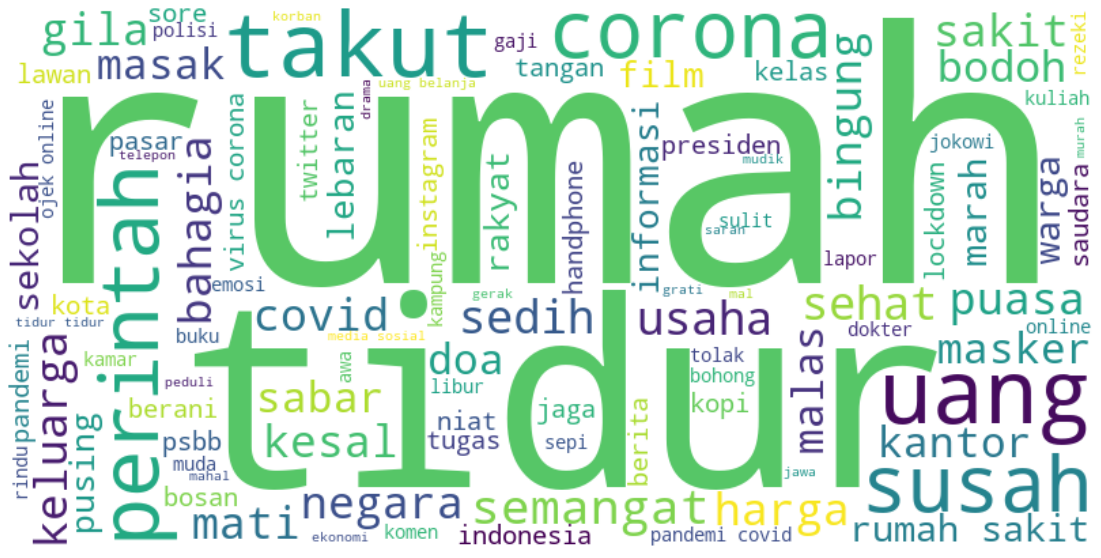

In [176]:
#menampilkan wordcloud
print('Hasil Wordcloud')
print('')
result = wordcloud(file, 'teks_string_data.txt')

In [140]:
#tweet_data_df = file.copy()
#second_stopwords_result = second_step_stopwords_process(tweet_data_df)
#second_stopwords_result.to_csv('data/wordcloud/covid/final result/final_result_{}.csv'.format(len(second_stopwords_result)))

In [152]:
#cols = [0]
#file.drop(file.columns[cols], axis=1, inplace=True)

In [153]:
#file.to_csv('data/wordcloud/covid/final result/final_result_{}.csv'.format(len(file)))

# LDA Model

In [ ]:
data_input = text_result[0]['tweet_tokens_lemma'].copy()
#data_input = data_input.str.split(',')
data_input = data_input.replace(',','', regex=True)
data_input = data_input.str.split()
data_input = data_input.tolist()

In [ ]:
id2word = corpora.Dictionary(data_input)
texts = data_input
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])

In [ ]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

In [ ]:
from pprint import pprint

num_topics = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
doc_lda

In [ ]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=10, 
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_input, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\\nCoherence Score: ', coherence_lda)

In [ ]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_input, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\\nCoherence Score: ', coherence_ldamallet)

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_input, start=2, limit=40, step=4)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_input, start=2, limit=10, step=1)

# Show graph
limit=40; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \\
of {coherence_values[best_result_index]}''')

In [ ]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

In [ ]:
import pyLDAvis.gensim

#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
p

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(optimal_model, corpus, id2word)

In [ ]:
len(data_reduksi)

In [ ]:
data_reduksi = text_result[0].head(50).copy()
data_test = data_reduksi['tweet']
#data_input = data_input.str.split(',')
data_test = data_test.replace(',','', regex=True)
data_test = data_test.str.split()
data_test = data_test.tolist()

In [ ]:
id2word_test = corpora.Dictionary(data_test)
texts_test = data_input
corpus_test = [id2word_test.doc2bow(text) for text in texts_test]

print(corpus_test[:1][0][:30])

In [ ]:
lda_model[corpus_test[9]]

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus_test, texts=texts_test):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,2), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus_test, texts=texts_test)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()